In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img, img_to_array, array_to_img
from keras.datasets import mnist
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, auc, roc_curve
from tensorflow.keras.applications import InceptionResNetV2  # Use Inception-ResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


In [7]:
# Check GPU availability
print(tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Load the dataset and visualize images
labels = os.listdir("/kaggle/input/augmented-dataset-drowsiness-detection/train")


In [9]:
# Load the data using ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30
)

In [10]:
# Load the dataset and split into training and testing sets
directory = "/kaggle/input/augmented-dataset-drowsiness-detection/train"
target_size = (120, 120)
batch_size = 11600 # Adjust batch size as needed

# Load the dataset and split into training and testing sets
data = datagen.flow_from_directory(
    directory,
    target_size=target_size,
    batch_size=batch_size,  # Specify batch size here
    class_mode='categorical',
    subset='training'
)

# Split the data into training and testing sets
x, y = data.next()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Encode the labels using one-hot encoding
label_bin = LabelBinarizer()
y_train = label_bin.fit_transform(y_train)
y_test = label_bin.transform(y_test)

Found 11600 images belonging to 4 classes.


In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

In [12]:
# Create the Inception-ResNetV2 base model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(120, 120, 3))


219055592/219055592 [==============================] - 7s 0us/step


In [13]:

# Add custom layers for classification on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])


In [14]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False


In [15]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                98368     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 54,435,364
Trainable params: 98,628
Non-tr

In [16]:
# Train the model
hist = model.fit(x_train, y_train, epochs=110, validation_data=(x_test, y_test), batch_size=200)  # Specify batch size here

Epoch 1/110
47/47 [==============================] - 32s 312ms/step - loss: 0.7865 - accuracy: 0.6367 - val_loss: 0.4422 - val_accuracy: 0.7642
Epoch 2/110
47/47 [==============================] - 8s 169ms/step - loss: 0.4947 - accuracy: 0.7268 - val_loss: 0.3982 - val_accuracy: 0.7694
Epoch 3/110
47/47 [==============================] - 9s 191ms/step - loss: 0.4395 - accuracy: 0.7544 - val_loss: 0.3664 - val_accuracy: 0.8056
Epoch 4/110
47/47 [==============================] - 8s 172ms/step - loss: 0.4091 - accuracy: 0.7758 - val_loss: 0.3609 - val_accuracy: 0.8060
Epoch 5/110
47/47 [==============================] - 9s 194ms/step - loss: 0.3871 - accuracy: 0.7859 - val_loss: 0.3528 - val_accuracy: 0.8147
Epoch 6/110
47/47 [==============================] - 8s 171ms/step - loss: 0.3798 - accuracy: 0.7849 - val_loss: 0.3563 - val_accuracy: 0.7914
Epoch 7/110
47/47 [==============================] - 9s 193ms/step - loss: 0.3737 - accuracy: 0.7948 - val_loss: 0.3442 - val_accuracy: 0.810

In [17]:
# Save the model
model.save("drowsiness_inceptionv4.h5")
model.save("drowsiness_inceptionv4.model")

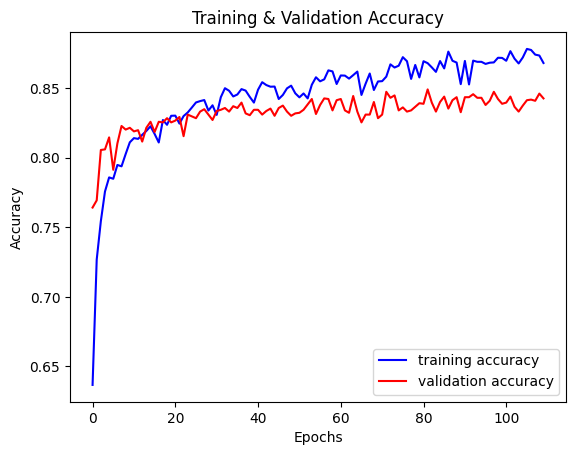

In [18]:
# Plot accuracy and loss
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="training accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

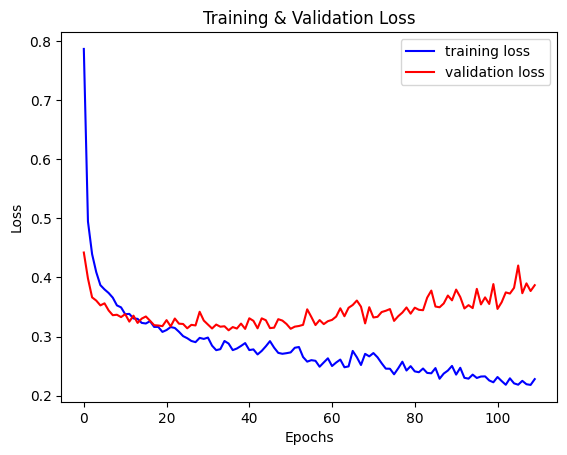

In [19]:
plt.plot(epochs, loss, "b", label="training loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()


In [20]:
# Make predictions and evaluate the model
y_true = np.argmax(y_test, axis=1)
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)


73/73 [==============================] - 8s 49ms/step


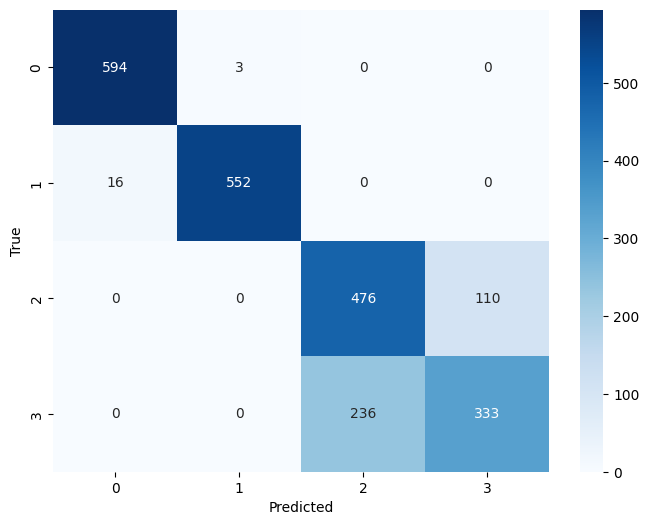

In [21]:
# Confusion Matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
# Print the confusion matrix
print("Confusion Matrix:\n", confusion_mtx)

Confusion Matrix:
 [[594   3   0   0]
 [ 16 552   0   0]
 [  0   0 476 110]
 [  0   0 236 333]]


In [23]:
# Accuracy Score
accuracy = np.sum(y_true == y_pred_classes) / len(y_true)
print("Accuracy:", accuracy)


Accuracy: 0.8426724137931034


In [26]:
# Classification Report
from sklearn.metrics import classification_report
class_report = classification_report(y_true, y_pred_classes, target_names=labels)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

      Closed       0.97      0.99      0.98       597
        Open       0.99      0.97      0.98       568
        yawn       0.67      0.81      0.73       586
     no_yawn       0.75      0.59      0.66       569

    accuracy                           0.84      2320
   macro avg       0.85      0.84      0.84      2320
weighted avg       0.85      0.84      0.84      2320



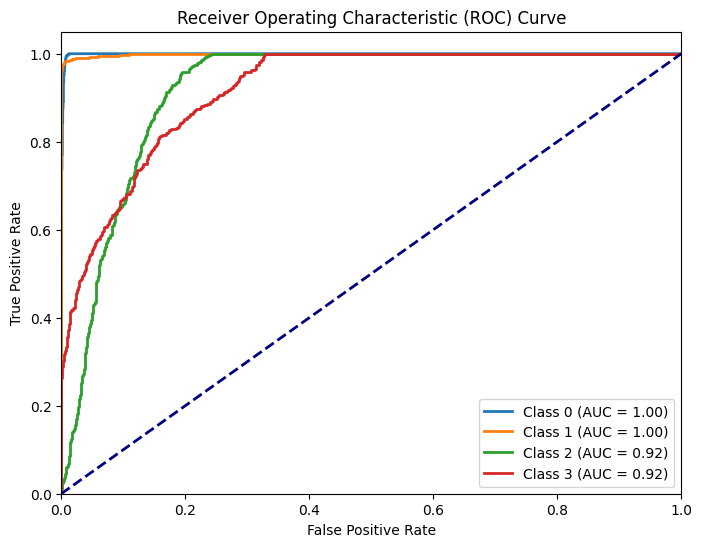

In [27]:
# Compute ROC curves and AUC for each class
n_classes = 4
fpr = dict()
tpr = dict()

roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
